<a href="https://colab.research.google.com/github/Mehak-shahani/my-projects-/blob/main/AI_Image_Classifier_with_PyTorch_and_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install torch torchvision matplotlib


In [8]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms  # Ensure transforms is imported here
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Download and prepare the CIFAR-10 dataset
data_dir = '/content/cifar10'



In [10]:
# Define the transformations: Normalizing and augmentations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 (required by pretrained models)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet
])

In [11]:
# Download train and test datasets
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

# DataLoader for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10
Files already downloaded and verified


In [12]:
# Load the pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10 (10 classes instead of ImageNet's 1000 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [13]:
# Check if GPU is available and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # Move data to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


In [15]:
# Train the model
train_model(model, criterion, optimizer, train_loader, num_epochs=5)

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model
evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'cifar10_resnet18.pth')

Epoch [1/5], Loss: 0.6663, Accuracy: 77.42%
Epoch [2/5], Loss: 0.3941, Accuracy: 86.57%
Epoch [3/5], Loss: 0.2806, Accuracy: 90.29%
Epoch [4/5], Loss: 0.2136, Accuracy: 92.77%
Epoch [5/5], Loss: 0.1558, Accuracy: 94.53%
Test Accuracy: 89.17%


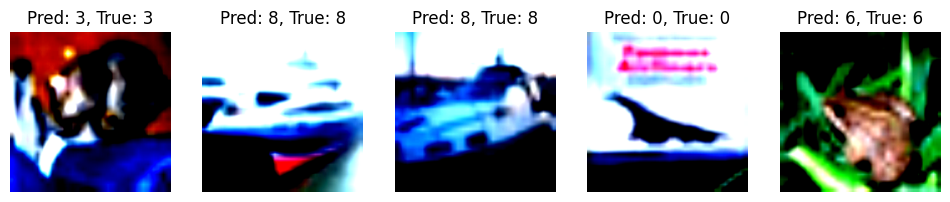

In [16]:
# Function to visualize some predictions
def visualize_predictions(model, test_loader):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Plot images
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        axes[i].imshow(images[i].cpu().permute(1, 2, 0).numpy())
        axes[i].set_title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader)